<a href="https://colab.research.google.com/github/eduvaladao/aulas_bigdata_astro_CBPF/blob/main/aula05_CBPF_Big_Data_Dense_Network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

<font size="5"> Photometric redshifts with Dense Network
    
<font size="2">
    
This notebook was adapted from the one developed by Gabriel Teixeira for the Big Data and Astroinformatics class - prof. Clécio R. Bom
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>
    
**Contact:** debom@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>

# Baixando os dados:

In [1]:
!wget -O specz_catalog_XIIIecbpf.fits "https://www.dropbox.com/s/38zmuj2zxuoigzk/specz_catalog_XIIIecbpf.fits?dl=1"
data_file = "specz_catalog_XIIIecbpf.fits"

--2022-11-07 20:30:13--  https://www.dropbox.com/s/38zmuj2zxuoigzk/specz_catalog_XIIIecbpf.fits?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/38zmuj2zxuoigzk/specz_catalog_XIIIecbpf.fits [following]
--2022-11-07 20:30:13--  https://www.dropbox.com/s/dl/38zmuj2zxuoigzk/specz_catalog_XIIIecbpf.fits
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0093967678ac77a4b694498d13.dl.dropboxusercontent.com/cd/0/get/BwXIMmZx7lJPc1xNKVidCRvwzFNjVc5QJ1CIeFltR0fGsJxHSkeW5wLXNfCP48ZkVOVQJnG4qtaxnFTP8KDm07idqJTvrEv0UR6xCsT6WDFlpfFIhGRciYBoV2BXHkHx4LDRzez3N_Wp7IY764ESZZ_5VFqmGoE8rXDpod-N5MBgHg/file?dl=1# [following]
--2022-11-07 20:30:13--  https://uc0093967678ac77a4b694498d13.dl.dropboxusercontent.com/cd/0/get/BwXIMmZx7lJPc1xNKVidCRvwzFNjVc

# Abrindo os dados fits (catálogo) como uma Table do astropy:

In [2]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import os

In [3]:
def open_fits_catalog(fits_file):
    hdu_list = fits.open(fits_file, ignore_missing_end=True)
    hdu = hdu_list[1]    # table extensions can't be the first extension, so there's a dummy image extension at 0.
    data1 = hdu.data     # print hdu.header
    cols = hdu.columns   # print hdu_list 
    cat_table = Table(data1)
    return cat_table, cols

In [4]:
# dados_dir = '/home/dados229/gabriel/escolacbpf/'
# data_file = os.path.join(dados_dir, 'specz_catalog_ecbpf.fits')
data, cols = open_fits_catalog(data_file)  # ta faltando a banda z, n sei pq.
print(data)
print(cols)
print(data.info) 

    ra        dec      class  ... petroMagErr_r petroMag_i petroMagErr_i
--------- ------------ ------ ... ------------- ---------- -------------
146.62282  -0.95138526 GALAXY ...  0.03089815     18.05202  0.03665525  
146.59272  -0.76025604 GALAXY ...  0.01007535     16.50206  0.01019981  
 146.9108 -0.074559356 GALAXY ...  0.03387981     17.43746  0.04512536  
146.44831  -0.71339967 GALAXY ...  0.009233744    17.02182  0.008778921 
146.78847  -0.31065752 GALAXY ...  0.03382286     17.86618  0.03925543  
146.09369  -0.79308773 GALAXY ...  0.005180169    15.43335  0.004949708 
146.09369  -0.79308773 GALAXY ...  0.005180169    15.43335  0.004949708 
146.14358  -0.74164105 GALAXY ...  0.01563277     16.16855  0.01662161  
 146.7517  -0.40839151 GALAXY ...  0.005794456    15.66012  0.005502901 
146.72901  0.026971893 GALAXY ...  0.008034743    16.73619  0.007468184 
      ...          ...    ... ...           ...        ...           ...
16.216263  -0.64805448 GALAXY ...  0.01564686     1

# Arrumando os dados e retirando problemas (coisas que não sejam galáxias, valores estranhos etc):

In [5]:
# Changing the datatype of some columns from string to float.
df = data.to_pandas()       # transformando astropy Table para pandas dataframe.
df1 = df.iloc[:, 0:5]       # fazendo um novo dataframe com todas as rows da coluna 0 a 4.
df2 = df.iloc[:, -8:]       # fazendo um novo dataframe com todas as rows das 8 últimas colunas.
df3 = df2.apply(pd.to_numeric, errors='coerce')    # mudando o data type do dataframe df2 de string para float.
# 'coerce' força a transformar qualquer coisa esquisita (string diferente, espaço maluco) em NaN (Not a number).
# apply aplica o to_numeric a todas as colunas.
#print(df1)
#print(df3)
#df3.info()

df_new = pd.concat([df1, df3], axis=1)   # concatena os dataframes de acordo com as colunas.
df_new2 = df_new[df_new["petroMag_u"] > -9999.0] # constrói um data frame novo só com rows em que os objetos de petroMag_u sejam maior que -9999.0.
df_new3 = df_new2[df_new2['class'] != 'STAR  '] # tirando tudo que é estrela.
#print(df_new.info())    

from google.colab import drive
drive.mount('/content/drive')
df_new3.to_csv('/content/drive/MyDrive/specz_catalog_XIIIecbpf.csv', index=False)  # salva corretamente os dados.

data = Table.from_pandas(df_new3)   # transforma pandas dataframe para astropy Table.

Mounted at /content/drive


In [6]:
df_new3

,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,146.622820,-0.951385,GALAXY,0.371128,0.000069,22.40671,0.991268,20.32166,0.091261,18.62304,0.030898,18.05202,0.036655
1,146.592720,-0.760256,GALAXY,0.064959,0.000009,19.03327,0.089179,17.49610,0.010818,16.91567,0.010075,16.50206,0.010200
2,146.910800,-0.074559,GALAXY,0.242272,0.000086,20.18482,0.296445,19.53431,0.088922,18.03267,0.033880,17.43746,0.045125
3,146.448310,-0.713400,GALAXY,0.114698,0.000008,18.94475,0.047213,17.98683,0.009779,17.45100,0.009234,17.02182,0.008779
4,146.788470,-0.310658,GALAXY,0.056562,0.000015,20.73877,0.480484,18.73327,0.036661,18.14503,0.033823,17.86618,0.039255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175916,16.005106,-0.855950,GALAXY,0.065073,0.000007,18.20492,0.051291,17.21942,0.010603,16.86439,0.008551,16.60081,0.013409
175917,15.651509,-0.637366,GALAXY,0.191312,0.000035,20.34421,0.248613,18.83951,0.031803,17.65709,0.016823,17.13594,0.015663
175918,15.866415,-1.159094,GALAXY,0.137276,0.000023,19.12054,0.086672,17.90217,0.016173,17.00707,0.009946,16.62113,0.011164
175919,15.624099,-0.813441,GALAXY,0.237502,0.000043,20.28428,0.240426,18.76537,0.030472,17.38507,0.020422,16.88052,0.019217


# Fazendo histogramas das magnitudes em cada banda e dos redshifts espectroscópicos de cada galáxia:

35.53114
12.97298
33.69091
11.99488
30.69354
11.36325
34.07032
10.89046
35.53114
12.97298
33.69091
11.99488
30.69354
11.36325
34.07032
10.89046


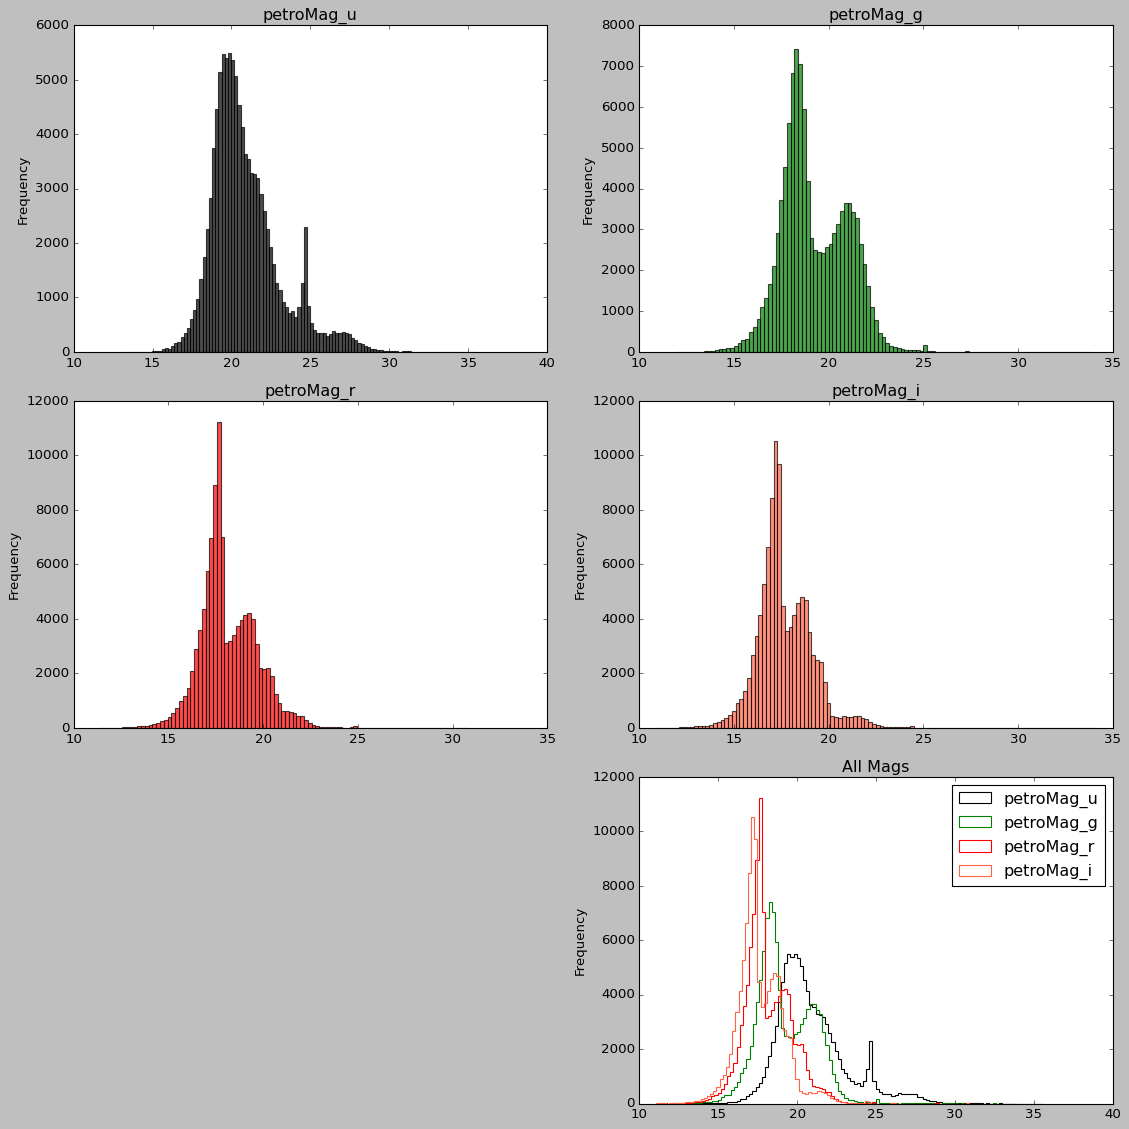

In [7]:
### MAG PLOTS

BANDS = ["u", "g", "r", "i"]
mags = ['petroMag_'+band for band in BANDS]

key_list = mags 
color_list = ['black', 'green', 'red', 'tomato', 'palevioletred']
hor = 2
ver = 3

plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i=0
binsize=0.2
def binarange(arr, binsize):
    print(np.nanmax(arr))
    print(np.nanmin(arr))
    return np.arange(np.nanmin(arr), np.nanmax(arr)+binsize, binsize)


for v in range(ver):
    for h in range(hor):
        if v==2:
            #ax = fig.add_subplot(gs[v, 0])
            #bins = binarange(data.field(key_list[i]), binsize)
            #ax = df_new[key_list[i]].plot.hist(bins=bins, color=color_list[i], alpha=0.7)
            #ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
            #ax.set_title(key_list[i])
            
            ax = fig.add_subplot(gs[v, 1])
            for c, key in enumerate(key_list):
                bins = binarange(data.field(key), binsize)
                ax = df_new3[key].plot.hist(bins=bins, color=color_list[c], alpha=1, label=key, histtype='step')
                #ax.hist(data.field(key), bins=bins, color=color_list[c], alpha=1, label=key, histtype='step')
            ax.set_title("All Mags")
            plt.legend()
            
            break
            i+=1
        
        
        mags = ['petroMag_'+band for band in BANDS]
        
        ax = fig.add_subplot(gs[v, h])
        bins = binarange(data.field(key_list[i]), binsize)
        ax = df_new3[key_list[i]].plot.hist(bins=bins, color=color_list[i], alpha=0.7)
        #ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
        ax.set_title(key_list[i])
        i+=1

plt.show
plt.savefig('/content/drive/MyDrive/HistogramspetroMAG.png')

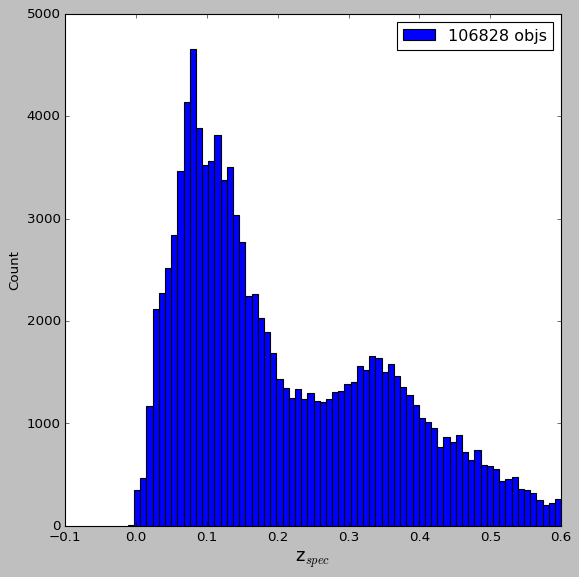

In [8]:
#ZSPEC PLOTS

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(np.array(data.field('z')), bins=70, color='blue', label=f'{len(data)} objs')
ax.set_xlabel('z$_{spec}$', fontsize=16)
ax.set_ylabel('Count')
plt.legend()
plt.savefig('/content/drive/MyDrive/Histogramspetroz.png')

In [ ]:
# ver list operators: 'https://www.educba.com/list-operations-in-python/'.

# Pré-processamento dos dados (separando em dados de treino, validação e teste e normalizando (ou reescalonando) esses dados):

In [9]:
# Preprocessing:

from sklearn.preprocessing import MinMaxScaler # The MinMaxscaler is a type of scaler that scales the minimum and maximum values to be 0 and 1 respectively.
# ver 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'.
# A scikit-learn é uma biblioteca de aprendizado de máquina de código aberto para a linguagem de programação Python.
# ver 'https://scikit-learn.org/stable/'.

np.random.seed(42) # All the random numbers generated after setting particular seed value are same across all the platforms/systems.
# It makes the random numbers predictable. All of them start with the same combination and every iteration after that will be the same.
''' Usando np.random.seed(42) e logo depois gerando uma lista de números aleatórios faz com que: se chamarmos np.random.seed(42) de novo e gerarmos 
uma lista de números aleatórios de novo, esses números serão iguais a lista feita anteriormente com np.random.seed(42) antes. '''
''' So when we write np.random.seed(any_number) the algorithm will output a particular set of numbers that is unique to the argument any_number. 
It's almost like a particular set of random numbers can be obtained if we pass the correct argument. '''
# ver 'https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do'.
# ver 'https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html'.


''' Podemos dividir os dados disponíveis em: Dados de treinamento: usado para treinar o modelo. Dados de validação: usado para comparação de 
diferentes modelos e hiperparâmetros. Dados de teste: usado para comprovar que aquele modelo realmente funciona. '''
''' the data points included in the training set are used to learn the parameters of the model of interest. '''
''' For instance, in Deep Learning we use the validation set in order to find the optimal network layer size, 
the number of hidden units and the regularization term. '''
'''  The testing set is used to evaluate the performance of this model and ensure that it can generalise well to new, unseen data points. '''
# ver 'https://towardsdatascience.com/training-vs-testing-vs-validation-sets-a44bed52a0e1'.
train_percentual = 7/10
train_cut1 = np.random.uniform(0, 1, len(data))  # The np.random.uniform function creates Numpy arrays that contain numbers drawn from a uniform distribution between [0,1).
# ver 'https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html'.
# ver 'https://www.sharpsightlabs.com/blog/np-random-uniform/'.
# The Uniform Distribution Draws Numbers From a Range, with a Constant Probability P(x) = 1/(b - a), [a, b). But the probability of drawing a number outside of that range is 0.
# array with len(data) elements (size of the array).
train_cut = train_cut1 < train_percentual # gera uma lista de booleans com True para os elementos de train_cut1 que forem menores que 7/10, e False pros que não forem.
train_data = data[train_cut] 
''' ^^^ Constrói um novo dataframe em que cada row é associado a um boolean da lista train_cut, os rows que tiverem True associado ficam e os que 
tiverem False são retirados. Assim, obtemos um novo dataframe, de treino, com (rows novas)/(rows velhas totais) = 74910/106828 = 7/10 escolhidas
de maneira semi-aleatória, com base numa distribuição uniforme. '''
print(train_cut) 
print(train_data)

test_val_data = data[~train_cut] # O operador ~ em pandas equivale ao not do python.
''' ^^^ Constrói um novo dataframe em que cada row é associado a um boolean inverso da lista train_cut, os rows que tiverem True (not False) associado
ficam e os que tiverem False (not True) são retirados. Assim, obtemos um novo dataframe, com (rows novas)/(rows velhas totais) = 31918/106828 = 3/10 escolhidas, 
ou seja, com as rows que ficaram de fora do dataframe anterior. '''
# ver 'https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas'.
print(test_val_data)

test_percentual = 2/3
test_cut = np.random.uniform(0, 1, len(test_val_data)) < test_percentual  # fazendo o mesmo procedimento de antes.

# dividindo o dataframe test_val_data "aleatoriamente" em 2/3 para teste e 1/3 para validação.
test_data = test_val_data[test_cut]  
val_data = test_val_data[~test_cut]

print('                                                     ')
print('*====================================================*')
print(f'Train Percent = {len(train_data)/len(data)*100:.2f}%')
print(f'Test Percent = {len(test_data)/len(data)*100:.2f}%')
print(f'Val Percent = {len(val_data)/len(data)*100:.2f}%')
print('*====================================================*')
print('                                                     ')

# Embaralhando os dados:

train_shuffler = np.random.choice(len(train_data), len(train_data), replace=False) # Generates a random sample from a given 1-D array.
# ver 'https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html'.
# first argument: If an ndarray, a random sample is generated from its elements. If an int, the random sample is generated as if it were np.arange(a).
# second argument: Output shape (size of the array).
# replace: Whether the sample is with or without replacement. Default is True, meaning that a value of the first argument can be selected multiple times.
train_data = train_data[train_shuffler] # Embaralha as rows do dataframe train_data de acordo com o array de índices embaralhados train_shuffler.

test_shuffler = np.random.choice(len(test_data), len(test_data), replace=False)
test_data = test_data[test_shuffler]

val_shuffler = np.random.choice(len(val_data), len(val_data), replace=False)
val_data = val_data[val_shuffler]

# Pegando as colunas de magnitudes e redshifts dos respectivos dataframes e transformando em numpy arrays:
# ndarray.T pega o array transposto. Ver 'https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html'.
''' .T transforma as rows em colunas e colunas em rows. Nesse caso o .T só serve para reorganizarmos o array na forma 
natural com cada coluna correspondendo a uma magnitude numa banda específica. '''
# ver 'https://stackoverflow.com/questions/3061761/numpy-array-dimensions'.
# # FIELD element: describes the datatype of a particular column of data. Return column[item] for recarray compatibility. Pega os dados de uma coluna.

x_train = np.array([train_data.field(mag) for mag in mags]).T
y_train = np.array(train_data.field('z'))

print(x_train.shape)
tabela1 = pd.DataFrame(x_train)
print(tabela1)
print(x_train.T.shape)
tabela2 = pd.DataFrame(x_train.T)
print(tabela2)

x_test = np.array([test_data.field(mag) for mag in mags]).T
y_test = np.array(test_data.field('z'))

x_val = np.array([val_data.field(mag) for mag in mags]).T
y_val = np.array(val_data.field('z'))

# Reescalonando (Normalizando) os dados para ficarem entre 0 e 1:
# Ver 'https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/'.
# Ver 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'.
''' The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

where min, max = 0, 1. '''

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
# Ver 'https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe'.
''' fit_transform() is used on the training data so that we can scale the training data and also learn the scaling 
parameters of that data. Here, the model built by us will learn the mean and variance of the features of the training 
set. These learned parameters are then used to scale our test data. '''
''' The fit method is calculating the mean and variance of each of the features present in our data. The transform 
method is transforming all the features using the respective mean and variance. '''
''' Now, we want scaling to be applied to our test data too and at the same time do not want to be biased with our
model. We want our test data to be a completely new and a surprise set for our model. The transform method helps us in this case. '''
''' Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test 
data. Thus, the parameters learned by our model using the training data will help us to transform our test data. '''
''' If we will use the fit method on our test data too, we will compute a new mean and variance that is a new scale 
for each feature and will let our model learn about our test data too. Thus, what we want to keep as a surprise is no 
longer unknown to our model and we will not get a good estimate of how our model is performing on the test (unseen) 
data which is the ultimate goal of building a model using machine learning algorithm. '''

print(x_train)
print(x_test)
print(x_val)

# np.max(x_test[:, 1])

[ True False False ...  True  True False]
    ra        dec     class  ... petroMagErr_r petroMag_i petroMagErr_i
--------- ----------- ------ ... ------------- ---------- -------------
146.62282 -0.95138526 GALAXY ...    0.03089815   18.05202    0.03665525
146.44831 -0.71339967 GALAXY ...   0.009233744   17.02182   0.008778921
146.78847 -0.31065752 GALAXY ...    0.03382286   17.86618    0.03925543
146.09369 -0.79308773 GALAXY ...   0.005180169   15.43335   0.004949708
146.09369 -0.79308773 GALAXY ...   0.005180169   15.43335   0.004949708
 146.7517 -0.40839151 GALAXY ...   0.005794456   15.66012   0.005502901
145.89838 -0.72280608 QSO    ...    0.01802959   18.39013    0.02051078
146.39902 -0.35038267 GALAXY ...    0.01994901   17.52203    0.02109401
146.28017 -0.40694922 GALAXY ...     0.0128714   15.87322    0.01304747
145.98758 -0.34255457 GALAXY ...    0.01371481    17.3434    0.01582657
      ...         ...    ... ...           ...        ...           ...
 15.36586 0.012588646 

# Criando nosso modelo de rede neural (machine learning) com camadas densas e dropout:

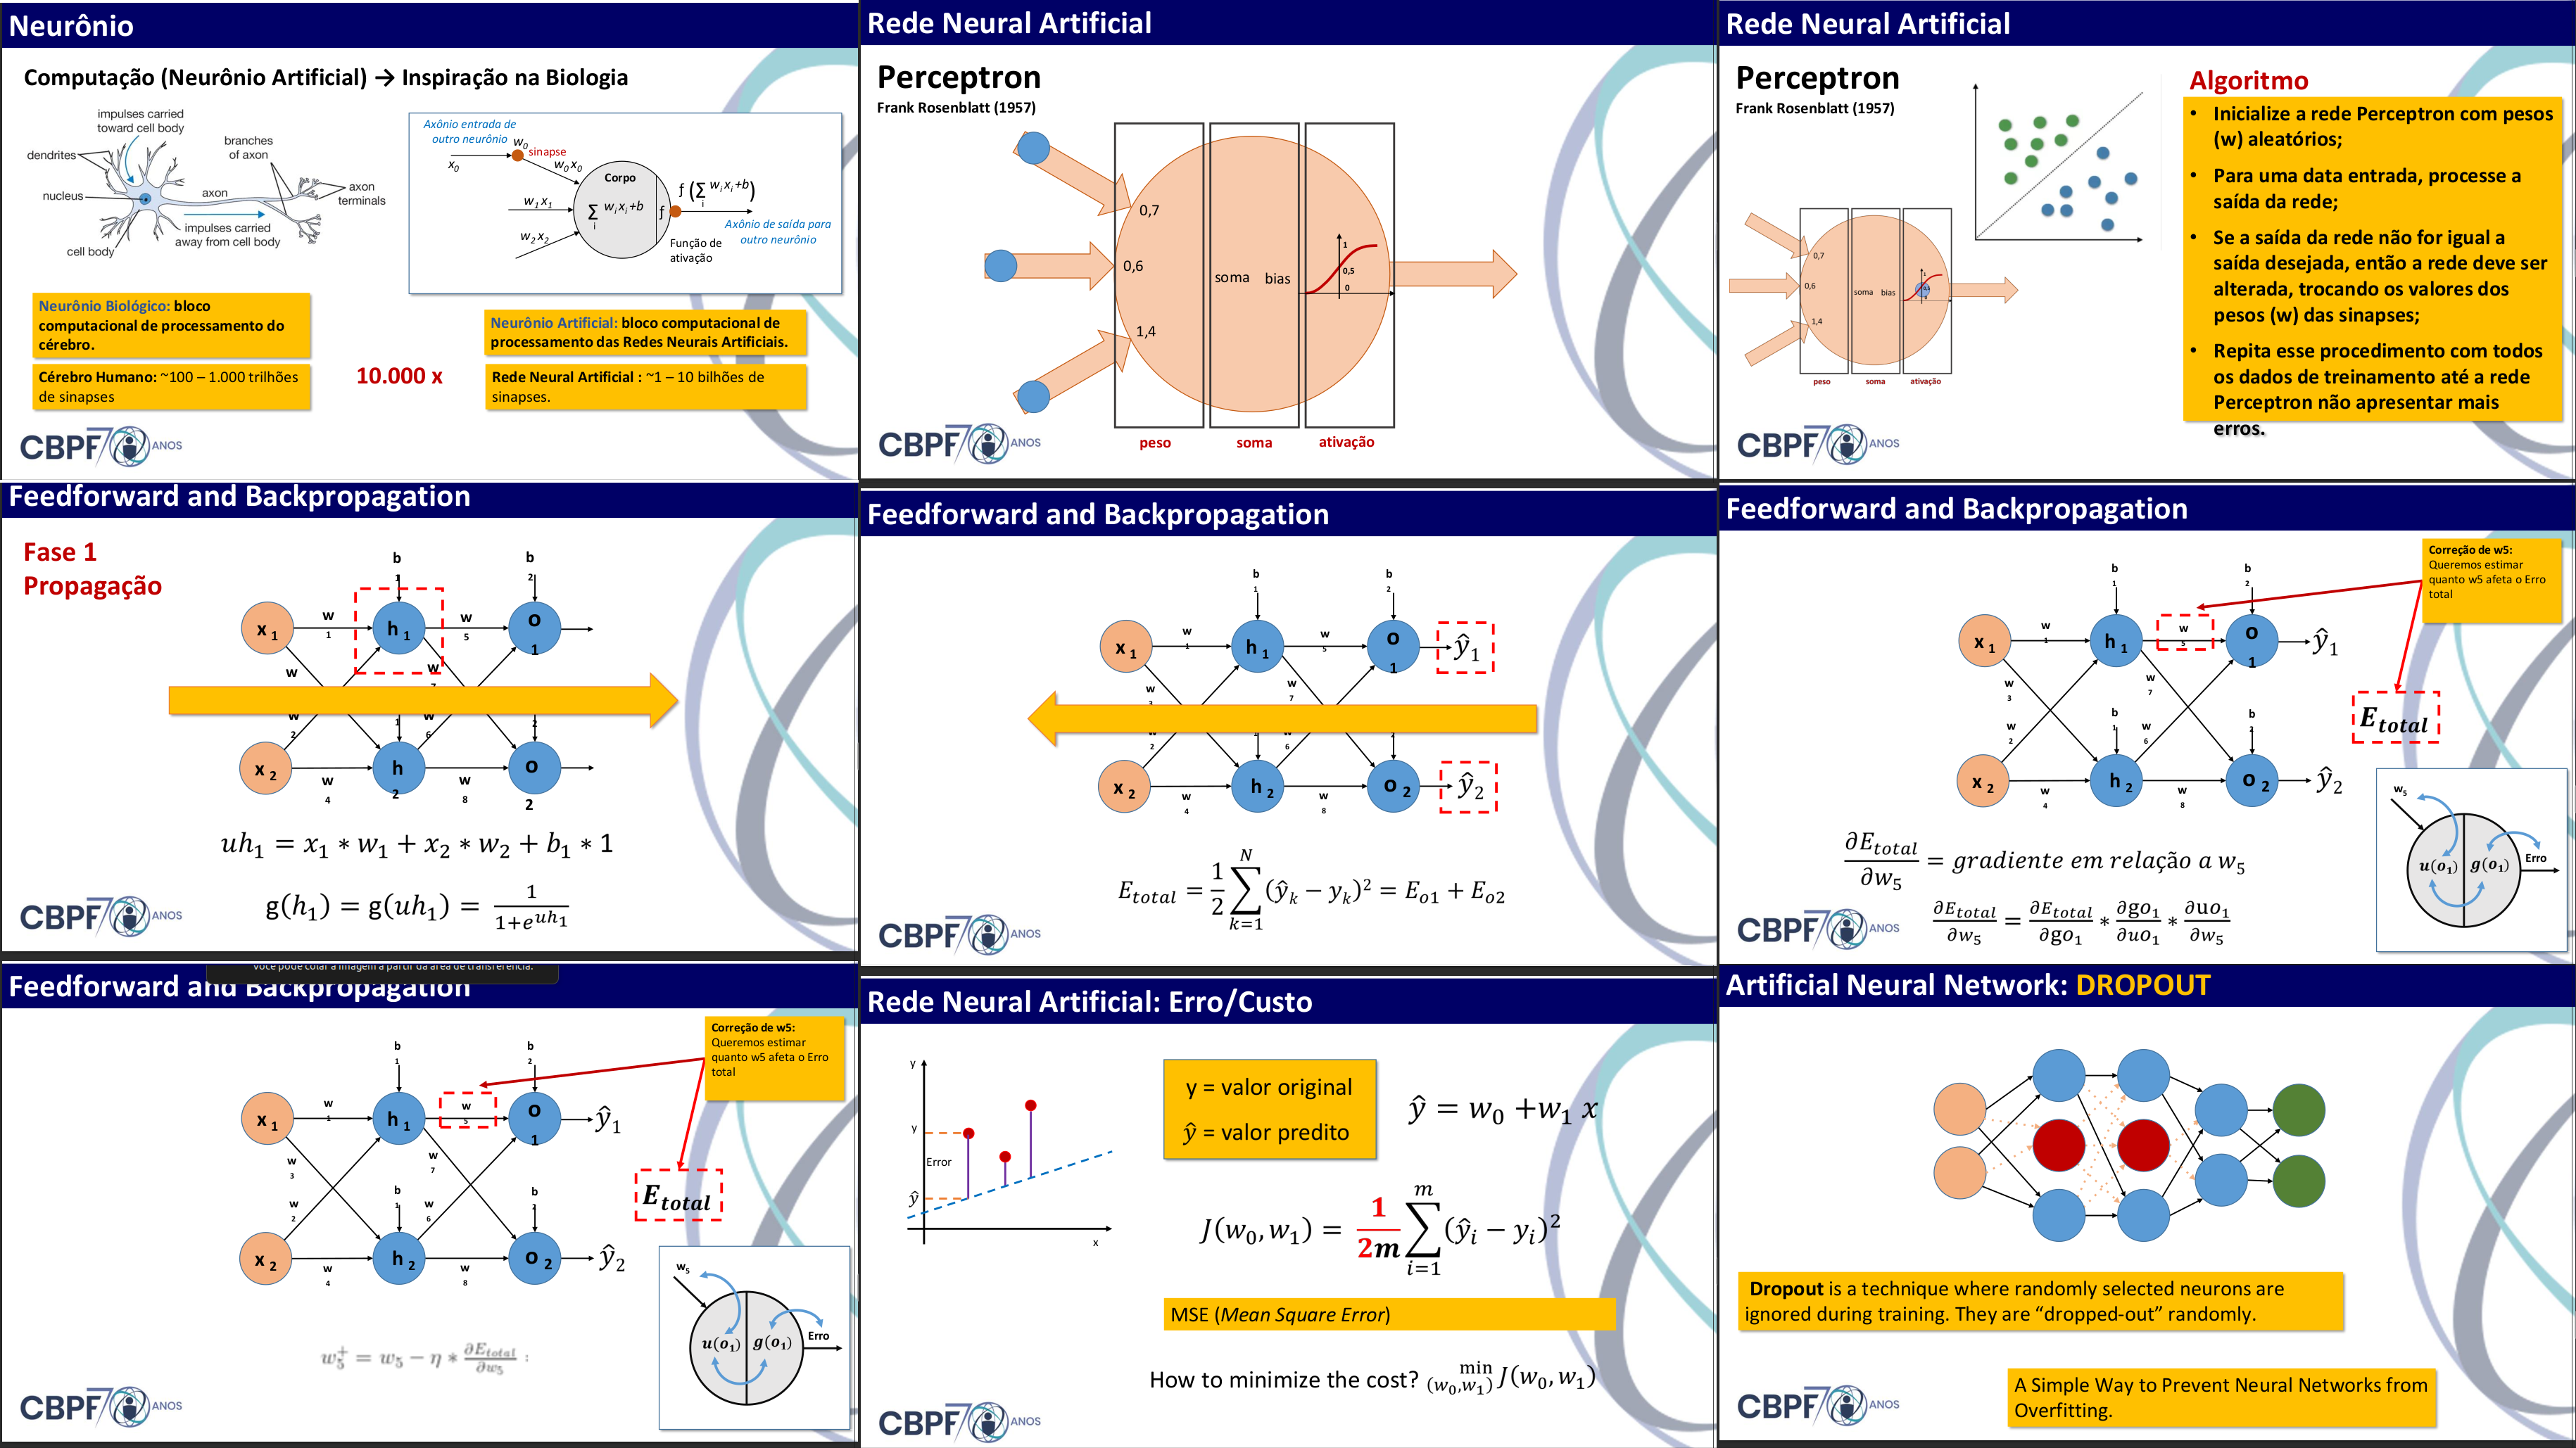

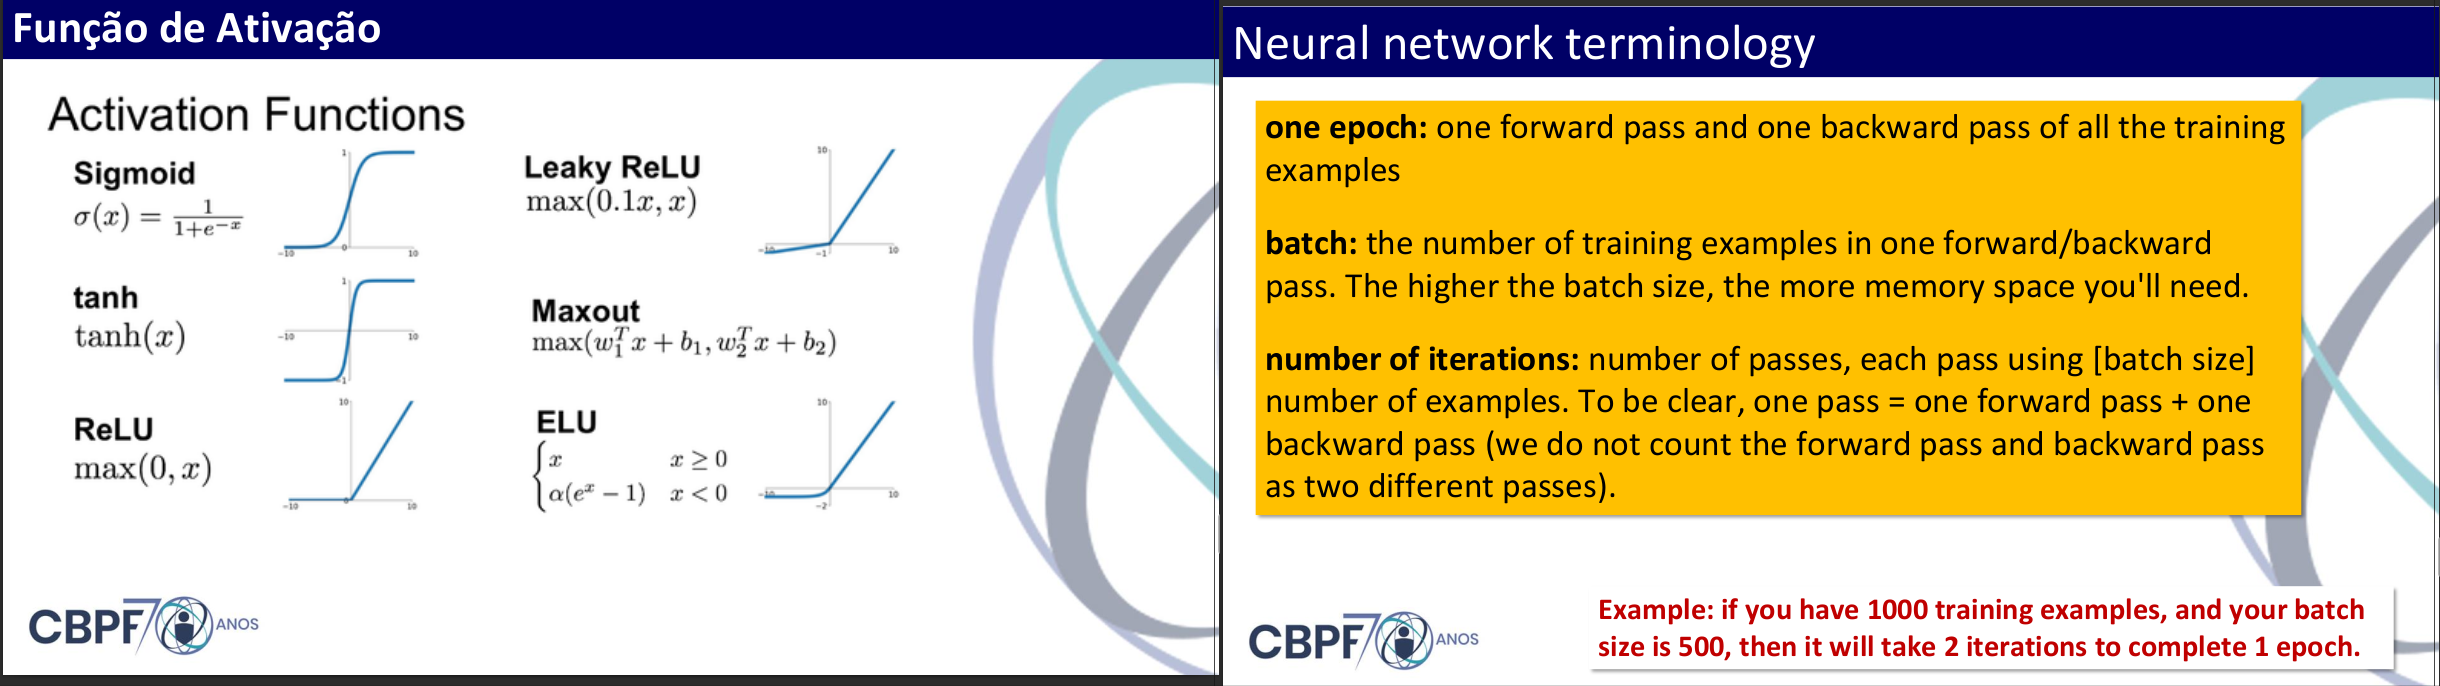

In [61]:
import tensorflow.keras as keras
print(keras.__version__)
''' TensorFlow é uma biblioteca de código aberto para aprendizado de máquina aplicável a uma ampla variedade de tarefas. 
É um sistema para criação e treinamento de redes neurais para detectar e decifrar padrões e correlações, análogo à forma 
como humanos aprendem e raciocinam. '''
# ver 'https://www.tensorflow.org/'.
''' O Keras é uma biblioteca de rede neural de código aberto escrita em Python. Ele é capaz de rodar em cima de TensorFlow, 
Microsoft Cognitive Toolkit, R, Theano, ou PlaidML. Projetado para permitir experimentação rápida com redes neurais profundas, 
ele se concentra em ser fácil de usar, modular e extensível. '''
# ver 'https://keras.io/about/'.
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "1"

print('Rede Neural densa com a primeira camada com 4 unidades (input), a segunda escondida com 512 neurônios e dropout, a terceira escondida com')
print('256 neurônios e dropout, a quarta escondida com 128 e dropout e a quinta com 1 unidade (output).')
def build_model(input_shape, nb_classes=1):
    ''' Layers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function 
    (the layer's call method) and some state, held in TensorFlow variables (the layer's weights). '''
    input_layer = keras.layers.Input(input_shape)
    ''' Input() is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain 
    attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. '''
    ''' input_shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be 
    batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known. '''
    # ver 'https://keras.io/api/layers/core_layers/input/'.
    ''' What flows between layers are tensors. Tensors can be seen as matrices, with shapes. In Keras, the input layer itself is not a layer, 
    but a tensor. It's the starting tensor you send to the first hidden layer. This tensor must have the same shape as your training data.  '''
    # ver 'https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc'.

    ''' In any neural network, a dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the 
    layer are connected to every neuron of its preceding layer '''
    layer_1 = keras.layers.Dense(512, activation='relu')(input_layer)
    ''' Just your regular densely-connected NN layer. Dense implements the operation: output = activation(dot(input, kernel) + bias) where 
    activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, 
    and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense. '''
    # units = 512: Positive integer, dimensionality of the output space (512 neurons, i.e. perceptrons).
    # activation = 'relu': Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
    # input na camada 1 = input_layer
    # ver 'https://keras.io/api/layers/core_layers/dense/'.
    # ver 'https://keras.io/api/layers/activations/#relu-function'.
    layer_1 = keras.layers.Dropout(rate=0.1)(layer_1)
    ''' Applies Dropout to the input. The Dropout layer randomly sets input units (neuronios da layer_1) to 0 with a frequency of rate at each step 
    during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is 
    unchanged. '''
    # rate = 0.2: Float between 0 and 1. Fraction of the input units to drop. Nesse caso, 20% dos neuronios são dropados.
    # ver 'https://keras.io/api/layers/regularization_layers/dropout/'.

    layer_2 = keras.layers.Dense(256, activation='relu')(layer_1)
    layer_2 = keras.layers.Dropout(rate=0.3)(layer_2)

    layer_3 = keras.layers.Dense(128, activation='relu')(layer_2)
    layer_3 = keras.layers.Dropout(rate=0.2)(layer_3) 

    output_layer = keras.layers.Dense(units=nb_classes,activation='linear')(layer_3)


    model = keras.models.Model(inputs=input_layer, outputs=output_layer) # Model groups layers into an object with training and inference features.
    # ver 'https://keras.io/api/models/model/'.
    print(model.summary()) # Dá um sumário da rede neural.
    # ver 'https://wandb.ai/ayush-thakur/dl-question-bank/reports/Keras-Layer-Input-Explanation-With-Code-Samples--VmlldzoyMDIzMDU'.
    return model

regressor = build_model(x_train.shape[1:])
print('Tensor shape of train dataset (magnitude columns):')
print(x_train.shape[1:]) 
# ver 'https://numpy.org/devdocs/reference/generated/numpy.shape.html'.
regressor.compile(loss='mse', optimizer=keras.optimizers.Nadam(), metrics=['accuracy']) # compile: configures the model for training.
# loss = 'mse': Loss function. Define a função custo/erro a ser minimizada, nesse caso é Mean Square Error.
''' optimizer: String (name of optimizer) or optimizer instance. keras.optimizers.Nadam() ver 'https://keras.io/api/optimizers/Nadam/'. Serve 
para otimizar o calculo da minimização, não cair em minimos locais etc: Adam optimization is a stochastic gradient descent method that is 
based on adaptive estimation of first-order and second-order moments. ver 'https://www.tensorflow.org/api_docs/python/tf/keras/optimizers'.'''
''' metrics: List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), 
function or a tf.keras.metrics.Metric instance. See tf.keras.metrics. Typically you will use metrics=['accuracy']. '''
# class Accuracy: Calculates how often predictions equal labels.
''' This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This 
frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count. '''
# ver 'https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy'.
# ver 'https://www.tensorflow.org/api_docs/python/tf/keras/metrics'.
# ver 'https://keras.io/api/models/model_training_apis/'.


# 586 iterations x 128 batch_size = 75.008 (all training data) in forward plus backward pass is 1 epoch.
batch_size = 128  # batch_size: the number of training data in one forward plus backward pass.
epochs = 20  # Epoch: One forward and backward pass of all training data.

# Trains the model for a fixed number of epochs (iterations on a dataset):
history = regressor.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                     verbose=1, validation_data=(x_val,y_val)) 
# x_train = Input data.
# y_train = Target data.
''' The learning algorithm finds patterns in the training data such that the input parameters correspond to the target. '''
''' The target variable is the feature of a dataset that you want to understand more clearly. It is the variable that the 
user would want to predict using the rest of the dataset (prever o redshift fotométrico com target data = redshift espectroscópico). '''
# batch_size: Integer or None. Number of samples per gradient update.
# epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.
# verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.
# ver 'https://keras.io/api/models/model_training_apis/'.

preds = regressor.predict(x_test) # Generates output predictions for the input samples.
# Pega o modelo treinado e validado, o regressor, e aplica nos dados de teste para obter a previsão.
# ver 'https://www.tensorflow.org/api_docs/python/tf/keras/Model'.

2.9.0
Rede Neural densa com a primeira camada com 4 unidades (input), a segunda escondida com 512 neurônios e dropout, a terceira escondida com
256 neurônios e dropout, a quarta escondida com 128 e dropout e a quinta com 1 unidade (output).
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_62 (Dense)            (None, 512)               2560      
                                                                 
 dropout_47 (Dropout)        (None, 512)               0         
                                                                 
 dense_63 (Dense)            (None, 256)               131328    
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
               

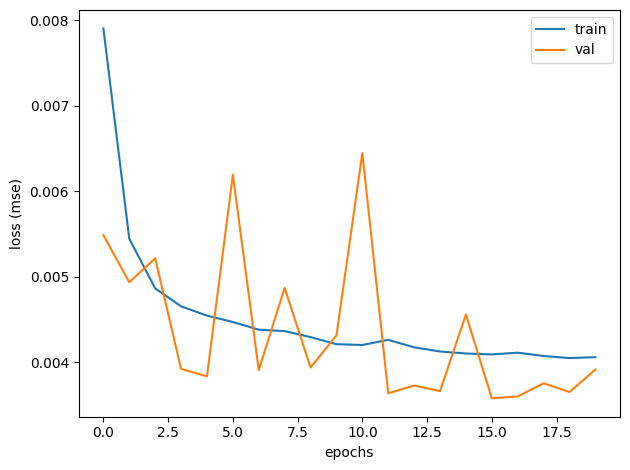

In [66]:
# TRAINING PLOTS

''' history = regressor.fit() returns: A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as 
validation loss values and validation metrics values (if applicable). '''
# ver 'https://keras.io/api/models/model_training_apis/'.
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epochs')
plt.ylabel('loss (mse)')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/loss_valloss.png')

In [67]:
### CALCULO DAS MÉTRICAS E PLOTS

def get_zstatistic(z, zspec):
    
    deltaz = z - zspec
    mean_bias = np.mean(deltaz)

    p16 = np.percentile(deltaz, 15.85) # Compute the q-th percentile of the data along the specified axis. ?
    p84 = np.percentile(deltaz, 84.05) # ver 'https://numpy.org/doc/stable/reference/generated/numpy.percentile.html'. ?
    sigma68 = 0.5*(p84 - p16) # ?
    median_bias = np.percentile(deltaz, 50)
    return mean_bias, median_bias, sigma68
    

def redshift_plot(z, zspec):
    
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 8))
    
    mean_bias, median_bias, sigma68 = get_zstatistic(z, zspec)

    text="\n $\sigma_{68}$: $"+str(round(sigma68, 3))+"$"
    text+="\n Mean Bias: $"+str(round(mean_bias, 3))+"$"
    text+="\n Median Bias: $"+str(round(median_bias, 3))+"$"
    ax = fig.add_subplot()
    
    # dispersão entre photo-z e spec-z:
    ax.scatter(np.array(zspec), np.array(z),
                       alpha = 0.5,
                       s=8, marker='o')
    
    # reta x = y:
    reta = [0, max([max(zspec), max(z)])]
    ax.plot(reta, reta,
              ls='dashed', color='black', lw=0.5)
    
    # limites e legendas:
    ax.set_ylim(min(z), max(z))
    ax.set_xlim(0, max(zspec))
    ax.set_ylabel("$z_{phot}$", fontsize=15)
    ax.set_xlabel("$z_{spec}$", fontsize=15)
    ax.text(0.7*max(zspec), .2*max(z), text, va="top", fontsize=12)
    
    plt.show()
    plt.savefig('/content/drive/MyDrive/zphoto_zspec_denseNN.png')


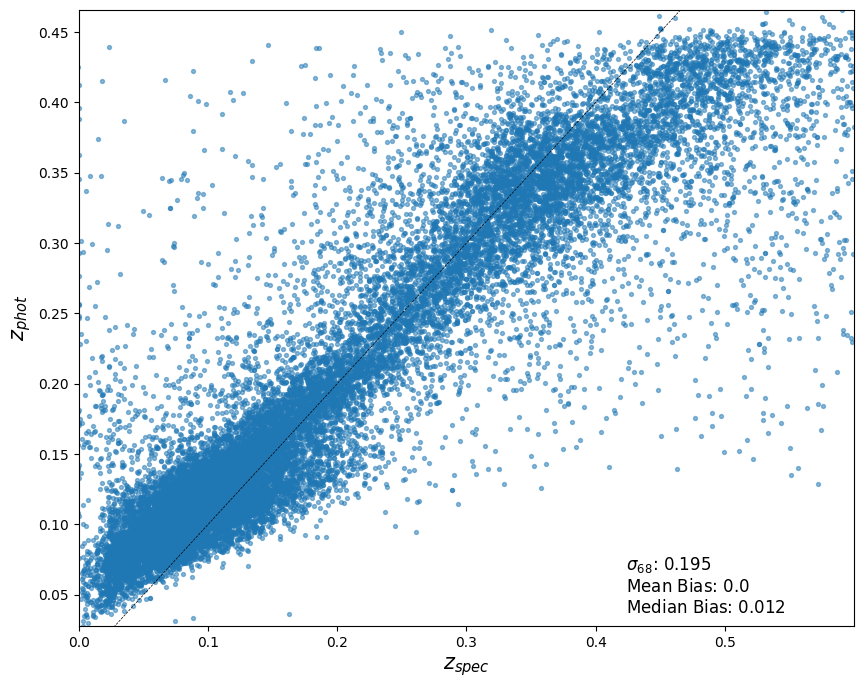

<Figure size 640x480 with 0 Axes>

In [68]:
redshift_plot(preds, y_test)


# Exercício: Demonstrate that a OL Least Square fit is equivalent of having a Maximum Likehood of a gaussian variable with a Linear model